In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[0]).unwrapped

discrete_actions = True

if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    
import gc

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
input_num = output_num*2
all_a = 0.1

In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale,lr):
    #Chose creatures based on fitness
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/4#population_out_size
        ex = math.ceil(ex**(1/(i+1)))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    np.random.shuffle(choice)
    
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,lr[p],device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_explore_all = []
    gen_exploit_all = []
    a_gen_all = []
    dis_loss_all = []
    dis_confidence_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r,_ = dis(real_batch)
            dis_out_r = dis_out_r.squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = torch.mean(torch.pow((dis_out_r[...,0]-rank),2))
            dis_error_real.backward(retain_graph=True)
            
            #discriminator confidence in its prediction
            dis_confidence = torch.mean(torch.abs(dis_out_r[...,1]-dis_error_real.detach()))
            dis_error_real.backward()
            
            dis_optimizer.step() 
            
            
            
            #generate children from population
            mutation = torch.from_numpy(np.random.uniform(0,all_a,batch_size)).type('torch.FloatTensor').to(device)
            child,a_gen = gen_children(population,device,gen,batch_size,a = mutation)
            a_gen = torch.mean(torch.abs(a_gen))
            #print("A gen : {}".format(torch.mean(a_gen)))
            #train discriminator
            dis_out_f,dis_out_last = dis(child)
            dis_out_f = dis_out_f.squeeze(-1)
            
            #z = torch.zeros(dis_out_r[...,1].shape).to(device)
            #dis_error_fake = torch.mean(torch.pow((dis_out_r[...,1]-z),2))
            #dis_error_fake.backward()
            
            gen_optimizer.zero_grad()
            
            #define generator loss
            variety = -torch.std(dis_out_f[...,0])#-torch.mean(torch.std(dis_out_last,-1))
            
            gen_error_exploration =  (variety)-torch.mean(dis_out_f[...,1])#+ a_gen
            gen_error_exploitation = -torch.mean(dis_out_f[...,0]) #+ torch.mean(a_gen)
            gen_error = (gen_error_exploration) + gen_error_exploitation 
            
            gen_error.backward()
            gen_optimizer.step() 
            
            #keep losses to draw graph 
            a_gen_all.append(a_gen)
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            dis_loss_all.append(dis_error_real)  
            dis_confidence_all.append(dis_confidence)
    print(rank)
    print(dis_out_r[...,0])
    #print(get_params(population[0]))
    #print()
            
    return gen_explore_all,gen_exploit_all, dis_loss_all,a_gen_all,dis_confidence_all


starting training
386
Measured population fitness : 0s
population fitness : [10. 11. 10. 10.  9.]
mean fit : 10.0
tensor([ 0.5000,  0.0000,  0.0000,  0.0000, -0.5000], device='cuda:0')
tensor([ 0.1499,  0.0092, -0.0358, -0.0031, -0.0744],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 4s
Evolved : 0s


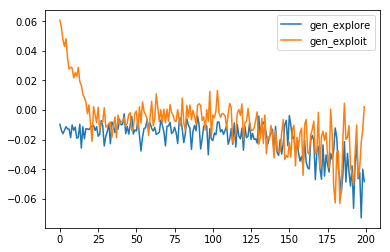

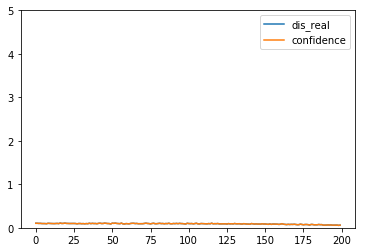

Generation 1  fitness : 11.0
#################################
Measured population fitness : 0s
population fitness : [ 9. 10. 10.  9.  8.]
mean fit : 9.2
tensor([ 0.1333,  0.1333,  0.1333,  0.4667, -0.2000, -0.5333,  0.1333, -0.2000,
         0.1333, -0.2000], device='cuda:0')
tensor([ 0.0037,  0.0776,  0.0012,  0.2171, -0.1231, -0.0066, -0.0199, -0.0500,
        -0.0182, -0.0166], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


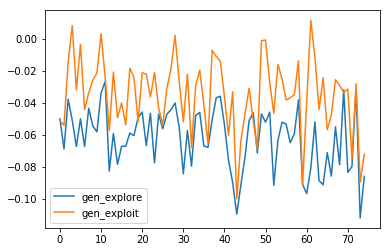

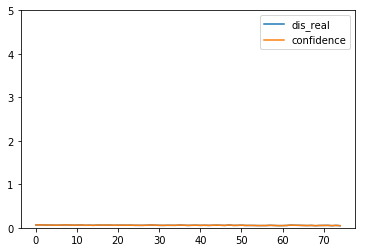

Generation 2  fitness : 10.0
#################################
Measured population fitness : 0s
population fitness : [ 9.  9.  9. 15.  9.]
mean fit : 10.2
tensor([-0.1143,  0.0286, -0.1143,  0.0286, -0.1143,  0.7429, -0.1143, -0.1143,
        -0.1143, -0.2571], device='cuda:0')
tensor([ 0.1432, -0.0870,  0.0465,  0.0213, -0.1135,  0.3886, -0.0981, -0.0737,
        -0.1945, -0.1112], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s
Evolved : 0s


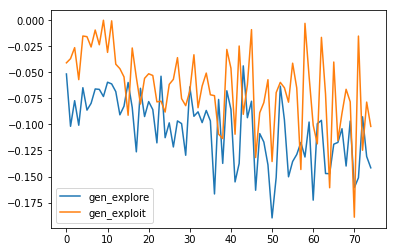

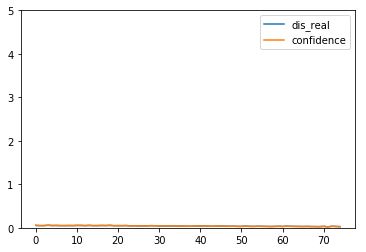

Generation 3  fitness : 15.0
#################################
Measured population fitness : 0s
population fitness : [  9. 222.  18.   9.  10.]
mean fit : 53.6
tensor([-0.0549, -0.0549, -0.0502, -0.0129, -0.0549, -0.0549, -0.0549, -0.0269,
         0.9404, -0.0549], device='cuda:0')
tensor([-0.0847,  0.0361,  0.1413,  0.1021,  0.0701, -0.0460, -0.0098,  0.2210,
         0.1882, -0.1476], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s
Evolved : 0s


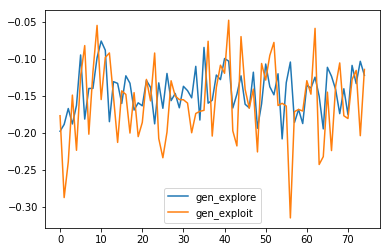

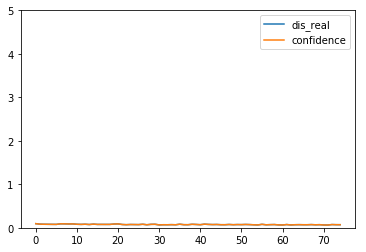

Generation 4  fitness : 222.0
#################################
Measured population fitness : 0s
population fitness : [ 10.  85.   9.   9. 160.]
mean fit : 54.6
tensor([-0.0819,  0.2686, -0.0865, -0.0819, -0.0865,  0.6191,  0.9088, -0.0865,
        -0.0445, -0.0865], device='cuda:0')
tensor([ 0.0262,  0.5238,  0.0230,  0.1710,  0.0862,  0.2744,  0.2241, -0.0411,
         0.0210, -0.0829], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


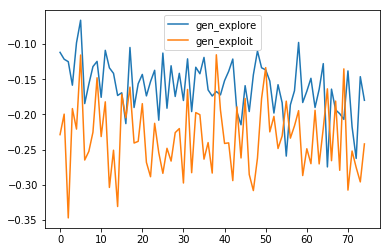

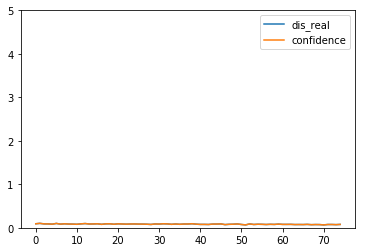

Generation 5  fitness : 160.0
#################################
Measured population fitness : 0s
population fitness : [125. 349. 113. 205. 126.]
mean fit : 183.6
tensor([ 0.0923,  0.1744, -0.1306,  0.3122,  0.2125,  0.4442,  0.8665, -0.1306,
        -0.1277,  0.2096], device='cuda:0')
tensor([ 0.3663,  0.3852, -0.1038,  0.2336,  0.1334,  0.2862,  0.3486, -0.1033,
         0.1098,  0.2213], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


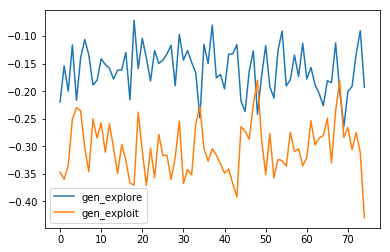

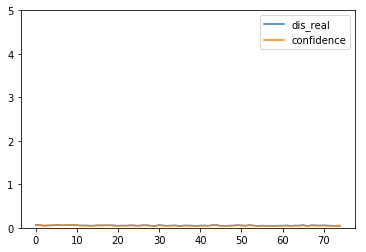

Generation 6  fitness : 349.0
#################################
Measured population fitness : 0s
population fitness : [ 15. 198. 218. 340. 331.]
mean fit : 220.4
tensor([ 0.7702,  0.7966,  0.1397,  0.3537, -0.1829,  0.1045,  0.4124,  0.3743,
         0.7438,  0.1426], device='cuda:0')
tensor([0.5875, 0.5262, 0.1696, 0.2968, 0.2400, 0.5853, 0.2582, 0.3353, 0.5373,
        0.1414], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s
Evolved : 0s


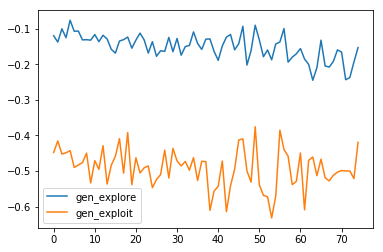

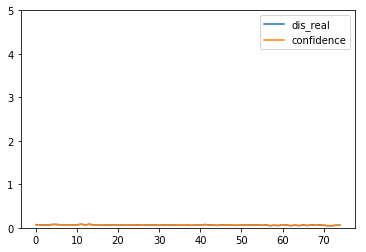

Generation 7  fitness : 340.0
#################################
Measured population fitness : 0s
population fitness : [238.  51.  78.  42.  88.]
mean fit : 99.4
tensor([-0.1910,  0.3457,  0.0231,  0.4043, -0.0062,  0.7621, -0.0854,  0.4630,
        -0.1118,  0.7357], device='cuda:0')
tensor([0.1119, 0.1345, 0.0648, 0.1462, 0.3294, 0.2800, 0.2235, 0.3413, 0.4386,
        0.2735], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


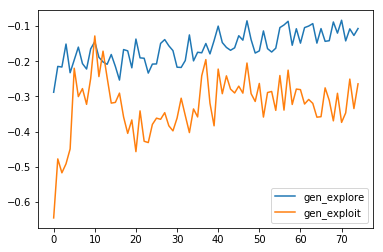

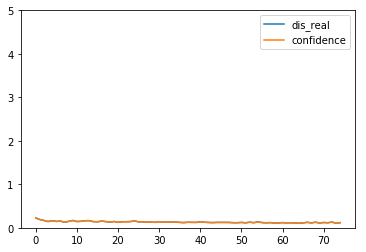

Generation 8  fitness : 238.0
#################################
Measured population fitness : 0s
population fitness : [ 79.  13. 106. 167.  17.]
mean fit : 76.4
tensor([ 0.0243, -0.1839, -0.0021,  0.4642,  0.2560, -0.1956, -0.0050, -0.0842,
         0.0771, -0.1106], device='cuda:0')
tensor([-0.1289,  0.0713,  0.1000, -0.0082,  0.0712, -0.0734, -0.0038, -0.0302,
         0.0460,  0.0451], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


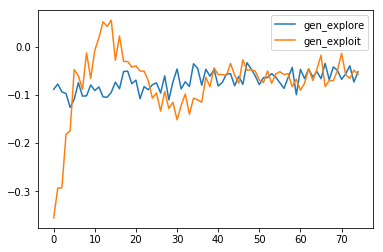

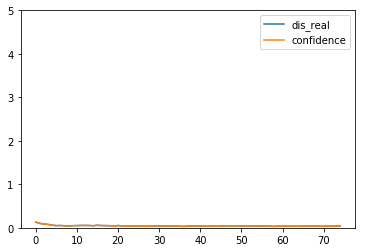

Generation 9  fitness : 167.0
#################################
Measured population fitness : 0s
population fitness : [303. 142. 296.  51. 229.]
mean fit : 204.2
tensor([ 0.5978,  0.4013,  0.0406, -0.0386, -0.2204,  0.1462, -0.2321, -0.1207,
         0.2195,  0.6183], device='cuda:0')
tensor([0.1501, 0.1469, 0.1580, 0.1289, 0.0566, 0.1885, 0.0131, 0.1644, 0.1034,
        0.1861], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s
Evolved : 0s


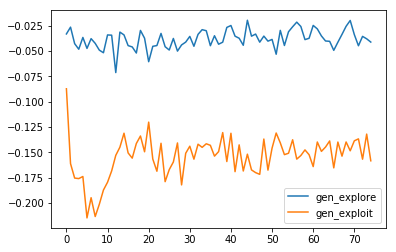

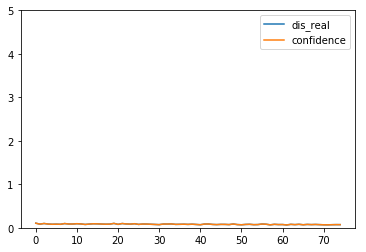

Generation 10  fitness : 303.0
#################################
Measured population fitness : 0s
population fitness : [243.   8. 223. 275. 196.]
mean fit : 189.0
tensor([ 0.5720,  0.1203, -0.1465, -0.2726,  0.5925,  0.2787,  0.3755,  0.4165,
         0.5104,  0.3579], device='cuda:0')
tensor([ 0.3852,  0.3659,  0.3229, -0.0282,  0.3925,  0.3423,  0.3377,  0.2143,
         0.2346,  0.2373], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s
Evolved : 0s


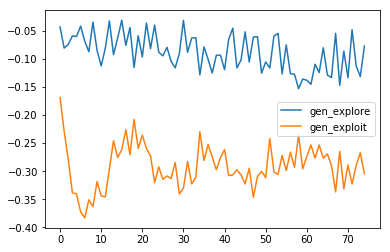

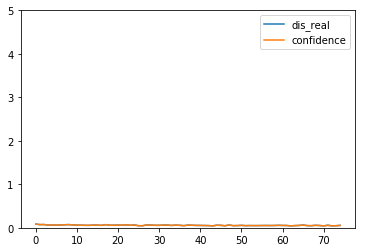

Generation 11  fitness : 275.0
#################################
Measured population fitness : 0s
population fitness : [299. 506. 214. 215. 306.]
mean fit : 308.0
tensor([ 0.3771,  0.3148,  0.2104,  0.3630,  0.1943,  0.1923, -0.2213,  0.7787,
         0.1562,  0.2506], device='cuda:0')
tensor([ 0.4213,  0.1781,  0.2541,  0.4759,  0.2708,  0.2080, -0.1634,  0.7209,
         0.1824,  0.1871], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s
Evolved : 0s


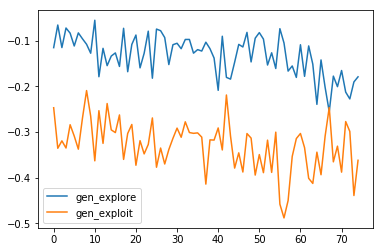

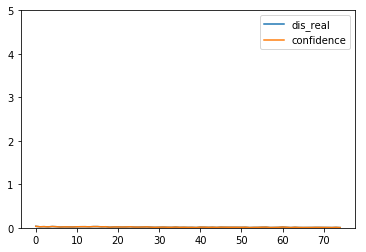

Generation 12  fitness : 506.0
#################################
Measured population fitness : 0s
population fitness : [194. 238. 204. 202. 107.]
mean fit : 189.0
tensor([ 0.1412,  0.1834, -0.0335,  0.1573,  0.3521,  0.7677,  0.1814,  0.3661,
         0.2296,  0.1613], device='cuda:0')
tensor([0.2632, 0.0876, 0.3415, 0.2386, 0.2499, 0.3706, 0.1609, 0.2051, 0.2917,
        0.3311], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


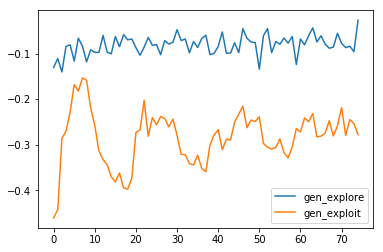

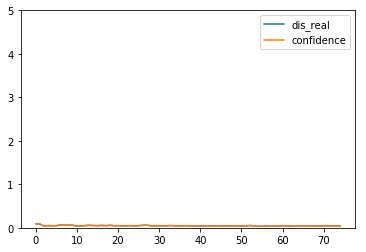

Generation 13  fitness : 238.0
#################################
Measured population fitness : 0s
population fitness : [172. 208. 176. 179. 401.]
mean fit : 227.2
tensor([ 0.0902,  0.1545,  0.1264,  0.5421,  0.0963,  0.2147,  0.1465,  0.0822,
         0.1425, -0.0483], device='cuda:0')
tensor([0.1047, 0.2027, 0.0606, 0.1924, 0.1448, 0.1741, 0.1333, 0.0715, 0.0803,
        0.1798], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


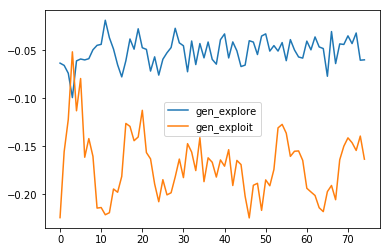

KeyboardInterrupt: 

In [4]:
population_size = 5
max_population = population_size
max_population_batch = 2
out_size = population_size
n_generations = 300

#randomly inititialise starting population
population = []

for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    
    #pars = torch.from_numpy(np.random.uniform(0,1,get_params(creat).numel())).type('torch.FloatTensor').to(device)
    pars = torch.tanh(get_params(creat))
    creat = set_params(creat,pars)
    population.append(creat)


print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
all_fitnesses = []
gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

for i in range(n_generations):
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0001,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0001,betas=(0.9,0.999))
   
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    all_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    #if len(all_fitnesses) > 5:
    #    all_fitnesses.pop(0)
        
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    #fitness_batch_normed = ((fitness_batch - np.mean(all_fitnesses))/np.std(all_fitnesses))
    fitness_batch_normed = (fitness_batch-np.mean(all_fitnesses))/(np.max(all_fitnesses)-np.min(all_fitnesses))
    #fitness_batch_normed = (fitness_batch-np.min(all_fitnesses))/np.sum(all_fitnesses)
    #Train GAN
    start_time = time.time()
    if i == 0:
        n_epochs = 200
    else:
        n_epochs = 75
    gen_explore_all,gen_exploit_all, dis_loss ,a_gen_all,dis_confidence_all= train_gan(population_batch
                                                                                       ,fitness_batch_normed,
              batch_size =fitness_batch.size,n_epochs = n_epochs)
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    mutation_scale = 0#.1
    mutation_rate = 0#.1
    mutation_rate = np.random.choice([0.1, 0], fitness_batch.shape,p=[mutation_rate,1-mutation_rate])
    
    all_r = 0.6
    all_r = np.random.choice([1, 0], p_fitness_.shape,p=[all_r,1-all_r])
    al_lr = all_r * np.abs(np.random.normal(scale = 1,size = p_fitness_.shape))*all_a
   # al_lr = np.array([0]*p_fitness_.size)
    #mate and mutate population
    start_time = time.time()
    population = evolve(population,out_size,gen,p_fitness_,
                                        mutation_rate,mutation_scale,al_lr)
    
    print("Evolved : {}s".format(int(time.time() - start_time)))
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    #plt.plot(a_gen_all,label='a')
    #plt.legend()
    #plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.plot(dis_confidence_all,label='confidence')
    plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [ ]:
#env = gym.make(envs[-2]).unwrapped

p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)


In [ ]:
scale = scale,size = creature.shapefitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 50000)
print(fitness)

In [ ]:
y = torch.zeros([5,10])
print(torch.mean(torch.std(y,-1)))

In [ ]:
#changed exploration coefficient